<a href="https://colab.research.google.com/github/devayanibornare/Spark-Foundation-Project/blob/main/Spark_Foundation_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Stock-Market-Prediction-using-Numerical-and-Textual-Analysis**

**GRIP May 2021 Intern**
**Devayani Bornare**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# importing library
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

import nltk
nltk.download('vader_lexicon')
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [10]:
# reading the datasets into pandas
stock_price = pd.read_csv('/content/drive/MyDrive/Spark Foundation/BSESN.csv')

In [11]:
stock_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,41352.171875,19000.0
1,2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,41558.570313,24300.0
2,2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,41673.921875,33300.0
3,2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,41681.539063,33600.0
4,2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,41642.660156,6200.0


In [12]:
stock_headlines = pd.read_csv('/content/drive/MyDrive/Spark Foundation/india-news-headlines.csv')

In [13]:
stock_headlines.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [14]:
len(stock_price), len(stock_headlines)

(252, 3424067)

In [15]:
stock_price.isna().any(), stock_headlines.isna().any()

(Date         False
 Open          True
 High          True
 Low           True
 Close         True
 Adj Close     True
 Volume        True
 dtype: bool, publish_date         False
 headline_category    False
 headline_text        False
 dtype: bool)

Stock Price

In [16]:
# dropping any null entries in our data 
stock_price.dropna(axis=0, inplace=True)

In [17]:
# dropping duplicate in data 
stock_price = stock_price.drop_duplicates()

# converting the datatype of column 'Date' from type object to type 'datetime'
stock_price['Date'] = pd.to_datetime(stock_price['Date']).dt.normalize()

# filtering the important columns
stock_price = stock_price.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# setting column 'Date' as index column
stock_price.set_index('Date', inplace=True)

#storing the data according to Date 
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price


,Close,Open,High,Low,Volume
Date,,,,,
2019-12-17,41352.171875,41052.359375,41401.648438,41005.179688,19000.0
2019-12-18,41558.570313,41442.750000,41614.769531,41358.468750,24300.0
2019-12-19,41673.921875,41571.820313,41719.289063,41456.398438,33300.0
2019-12-20,41681.539063,41746.199219,41809.960938,41636.109375,33600.0
2019-12-23,41642.660156,41548.261719,41701.621094,41474.609375,6200.0
...,...,...,...,...,...
2020-12-11,46099.011719,46060.320313,46309.628906,45706.218750,26300.0
2020-12-14,46253.460938,46284.699219,46373.339844,45951.531250,18400.0
2020-12-15,46263.171875,46287.390625,46350.300781,45841.671875,16400.0


Stock headlines

In [18]:
# dropping duplicates
stock_headlines = stock_headlines.drop_duplicates()

# converting data type of column 'Date' from type string to type 'datetime'
stock_headlines['publish_date'] = stock_headlines['publish_date'].astype(str)
stock_headlines['publish_date'] = stock_headlines['publish_date'].apply(lambda X: X[0:4]+'-'+X[4:6]+'-'+X[6:8])
stock_headlines['publish_date'] = pd.to_datetime(stock_headlines['publish_date']).dt.normalize()

# filtering the importing columns
stock_headlines = stock_headlines.filter(['publish_date', 'headline_text'])

# grouping the news headline according the Date
stock_headlines = stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda X:','.join(X)).reset_index()

#setting Date as index column
stock_headlines.set_index('publish_date', inplace=True)

# sorting the date according to the Date
stock_headlines = stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
2020-12-28,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,Man recovers charred remains of 'thief' from h...


Combining both Prices and Headlines

In [19]:
# concatenation of the datasets stock_price and stock_headlines
stock_data = pd.concat([stock_price, stock_headlines], axis=1)

stock_data.dropna(axis=0, inplace=True)

# displaying the combined data stock_data
stock_data

,Close,Open,High,Low,Volume,headline_text
2019-12-17,41352.171875,41052.359375,41401.648438,41005.179688,19000.0,After Jagannath Temple; Puri beach devpt plan ...
2019-12-18,41558.570313,41442.750000,41614.769531,41358.468750,24300.0,What is Citizenship (Amendment) Bill 2019: All...
2019-12-19,41673.921875,41571.820313,41719.289063,41456.398438,33300.0,Only 61% of CCA covered after revamp of canals...
2019-12-20,41681.539063,41746.199219,41809.960938,41636.109375,33600.0,I'm done playing the good girl; I want to be a...
2019-12-23,41642.660156,41548.261719,41701.621094,41474.609375,6200.0,Weekly Horoscope; December 22-28: Check predic...
...,...,...,...,...,...,...
2020-12-11,46099.011719,46060.320313,46309.628906,45706.218750,26300.0,Ways to get you in the mood for sex when you'r...
2020-12-14,46253.460938,46284.699219,46373.339844,45951.531250,18400.0,"No threat from Covid claims to balance sheets,..."
2020-12-15,46263.171875,46287.390625,46350.300781,45841.671875,16400.0,1;147 RT-PCR tests in a day; only 3 found +ve ...
2020-12-16,46666.460938,46573.308594,46704.968750,46402.199219,13100.0,Asmita Sood's favourite holiday destinations a...


In [20]:
# Sentiment Analysis
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neural'] = ''
stock_data['positive'] = ''
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neural,positive
2019-12-17,41352.171875,41052.359375,41401.648438,41005.179688,19000.0,After Jagannath Temple; Puri beach devpt plan ...,,,,
2019-12-18,41558.570313,41442.750000,41614.769531,41358.468750,24300.0,What is Citizenship (Amendment) Bill 2019: All...,,,,
2019-12-19,41673.921875,41571.820313,41719.289063,41456.398438,33300.0,Only 61% of CCA covered after revamp of canals...,,,,
2019-12-20,41681.539063,41746.199219,41809.960938,41636.109375,33600.0,I'm done playing the good girl; I want to be a...,,,,
2019-12-23,41642.660156,41548.261719,41701.621094,41474.609375,6200.0,Weekly Horoscope; December 22-28: Check predic...,,,,


In [21]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

# sentiment analyzer
sid = SentimentIntensityAnalyzer()
print('Start calculating sentiment scores:')

stock_data['compound'] = stock_data['headline_text'].apply(lambda X: sid.polarity_scores(X)['compound'])
print('Compound done')
stock_data['negative'] = stock_data['headline_text'].apply(lambda X: sid.polarity_scores(X)['neg'])
print('Negative done')
stock_data['neutral'] = stock_data['headline_text'].apply(lambda X: sid.polarity_scores(X)['neu'])
print('Neutral done')
stock_data['positive'] = stock_data['headline_text'].apply(lambda X:sid.polarity_scores(X)['pos'])
print('Positive done')
print('Stop')

stock_data.head()

Start calculating sentiment scores:
Compound done
Negative done
Neutral done
Positive done
Stop


,Close,Open,High,Low,Volume,headline_text,compound,negative,neural,positive,neutral
2019-12-17,41352.171875,41052.359375,41401.648438,41005.179688,19000.0,After Jagannath Temple; Puri beach devpt plan ...,-1.0000,0.179,,0.072,0.750
2019-12-18,41558.570313,41442.750000,41614.769531,41358.468750,24300.0,What is Citizenship (Amendment) Bill 2019: All...,-0.9999,0.143,,0.070,0.787
2019-12-19,41673.921875,41571.820313,41719.289063,41456.398438,33300.0,Only 61% of CCA covered after revamp of canals...,-0.9996,0.105,,0.055,0.840
2019-12-20,41681.539063,41746.199219,41809.960938,41636.109375,33600.0,I'm done playing the good girl; I want to be a...,-0.9999,0.156,,0.074,0.770
2019-12-23,41642.660156,41548.261719,41701.621094,41474.609375,6200.0,Weekly Horoscope; December 22-28: Check predic...,-0.9998,0.129,,0.078,0.793


In [22]:
# dropping unwanted 'headline_text' and rearranging column
stock_data.drop(['headline_text'], inplace=True, axis=1)
stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

# final stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2019-12-17,41352.171875,-1.0000,0.179,0.750,0.072,41052.359375,41401.648438,41005.179688,19000.0
2019-12-18,41558.570313,-0.9999,0.143,0.787,0.070,41442.750000,41614.769531,41358.468750,24300.0
2019-12-19,41673.921875,-0.9996,0.105,0.840,0.055,41571.820313,41719.289063,41456.398438,33300.0
2019-12-20,41681.539063,-0.9999,0.156,0.770,0.074,41746.199219,41809.960938,41636.109375,33600.0
2019-12-23,41642.660156,-0.9998,0.129,0.793,0.078,41548.261719,41701.621094,41474.609375,6200.0


**Feature Engineering of the Combined Data**

In [23]:
stock_data.isna().any()

Close       False
compound    False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [24]:
stock_data.describe(include='all')

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,37745.454117,-0.991440,0.126800,0.797364,0.075880,37804.237375,38071.182859,37422.826992,19134.000000
std,4535.304336,0.126322,0.021444,0.026876,0.012263,4507.985769,4380.974060,4647.212947,16540.261333
min,25981.240234,-1.000000,0.074000,0.730000,0.044000,26499.810547,27462.869141,25638.900391,0.000000
25%,34257.097656,-0.999900,0.111000,0.777000,0.067000,34369.659179,34779.932618,33975.389648,13125.000000
50%,38425.974610,-0.999700,0.127000,0.794000,0.076000,38489.480469,38750.359375,38234.869140,17000.000000
75%,41135.233399,-0.999500,0.140750,0.816750,0.084000,41179.222656,41376.482422,41023.923828,21075.000000
max,46890.339844,0.997800,0.199000,0.869000,0.126000,46774.320313,46992.570313,46627.601563,188300.000000


In [25]:
# displaying stock_data information 
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2019-12-17 to 2020-12-17
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     250 non-null    float64
 1   compound  250 non-null    float64
 2   negative  250 non-null    float64
 3   neutral   250 non-null    float64
 4   positive  250 non-null    float64
 5   Open      250 non-null    float64
 6   High      250 non-null    float64
 7   Low       250 non-null    float64
 8   Volume    250 non-null    float64
dtypes: float64(9)
memory usage: 19.5 KB


Stock Data Analysis

Text(0, 0.5, 'Close Price (INR)')

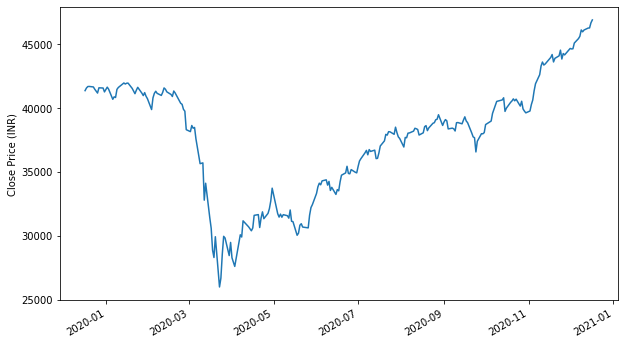

In [26]:
# setting plot size and labels
plt.figure(figsize=(10,6))

stock_data['Close'].plot()

#plt.title('Close Price')
#plt.xlabel('Date')
plt.ylabel('Close Price (INR)')

In [27]:
# Calculating 7 day rolling mean
stock_data.rolling(7).mean().head(20)

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2019-12-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-26,41504.840960,-0.999857,0.142857,0.784857,0.072429,41512.814732,41642.010045,41355.246652,18057.142857
2019-12-27,41536.693639,-0.999843,0.141857,0.786000,0.072143,41547.774554,41671.955915,41392.352679,16214.285714
2019-12-30,41536.612165,-0.999843,0.145571,0.781714,0.072857,41582.563058,41686.236049,41405.911272,13557.142857
2019-12-31,41476.585938,-0.999886,0.153143,0.770714,0.076429,41587.658482,41670.264509,41367.101563,9600.000000


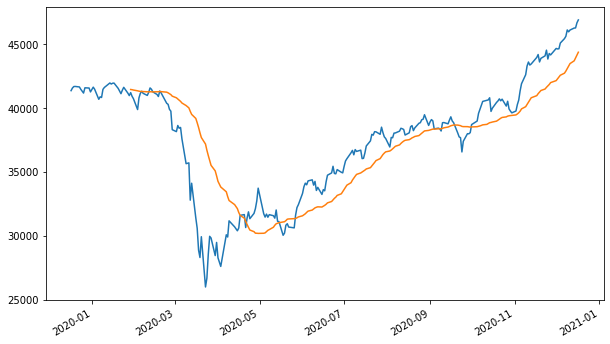

In [28]:
# setting figure size 
plt.figure(figsize=(10,6))

#plotitng the close price and a 30 day rolling mean of close price 
stock_data['Close'].plot()
stock_data.rolling(window=30).mean()['Close'].plot()



In [29]:
# Displaying Stock Data
stock_data

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2019-12-17,41352.171875,-1.0000,0.179,0.750,0.072,41052.359375,41401.648438,41005.179688,19000.0
2019-12-18,41558.570313,-0.9999,0.143,0.787,0.070,41442.750000,41614.769531,41358.468750,24300.0
2019-12-19,41673.921875,-0.9996,0.105,0.840,0.055,41571.820313,41719.289063,41456.398438,33300.0
2019-12-20,41681.539063,-0.9999,0.156,0.770,0.074,41746.199219,41809.960938,41636.109375,33600.0
2019-12-23,41642.660156,-0.9998,0.129,0.793,0.078,41548.261719,41701.621094,41474.609375,6200.0
...,...,...,...,...,...,...,...,...,...
2020-12-11,46099.011719,-0.9999,0.147,0.773,0.080,46060.320313,46309.628906,45706.218750,26300.0
2020-12-14,46253.460938,-0.9993,0.110,0.812,0.079,46284.699219,46373.339844,45951.531250,18400.0
2020-12-15,46263.171875,-0.9998,0.120,0.807,0.072,46287.390625,46350.300781,45841.671875,16400.0
2020-12-16,46666.460938,-0.9994,0.103,0.824,0.073,46573.308594,46704.968750,46402.199219,13100.0


Data For Modelling

In [30]:
# calculating data for use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use 

# printing number of records in the training and test datasets
print("Number of records in training data: ", train_end)
print("Number of records in test data: ", total_data - train_end)

Number of records in training data:  199
Number of records in test data:  51


In [31]:
# predicting one step ahead
steps_to_predict = 1

close_price = stock_data.iloc[start:total_data,0]# close
compound = stock_data.iloc[start:total_data,1]# compound
negative = stock_data.iloc[start:total_data,2]# neg
neutral = stock_data.iloc[start:total_data,3]# neu
positive = stock_data.iloc[start:total_data,4]# pos
open_price = stock_data.iloc[start:total_data,5]# open
high = stock_data.iloc[start:total_data,6]# high
low = stock_data.iloc[start:total_data,7]# low
volume = stock_data.iloc[start:total_data,8]#volume


# printing close prices
print("Close Price:")
close_price

Close Price:


2019-12-18    41558.570313
2019-12-19    41673.921875
2019-12-20    41681.539063
2019-12-23    41642.660156
2019-12-24    41461.261719
                  ...     
2020-12-11    46099.011719
2020-12-14    46253.460938
2020-12-15    46263.171875
2020-12-16    46666.460938
2020-12-17    46890.339844
Name: Close, Length: 249, dtype: float64

In [32]:
# Shifting next day close 
close_price_shifted = close_price.shift(-1)

# shifting next day compound
compound_shifted = compound.shift(-1)

# concatenating the captured training data into dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column name of the received stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
2019-12-18,41558.570313,41673.921875,-0.9999,-0.9996,24300.0,41442.750000,41614.769531,41358.468750
2019-12-19,41673.921875,41681.539063,-0.9996,-0.9999,33300.0,41571.820313,41719.289063,41456.398438
2019-12-20,41681.539063,41642.660156,-0.9999,-0.9998,33600.0,41746.199219,41809.960938,41636.109375
2019-12-23,41642.660156,41461.261719,-0.9998,-0.9999,6200.0,41548.261719,41701.621094,41474.609375
2019-12-24,41461.261719,41163.761719,-0.9999,-0.9999,4400.0,41684.511719,41702.980469,41423.070313
2019-12-26,41163.761719,41575.140625,-0.9999,-0.9999,5600.0,41543.800781,41543.800781,41132.890625
2019-12-27,41575.140625,41558.000000,-0.9999,-0.9999,6100.0,41297.078125,41611.269531,41264.921875
2019-12-30,41558.000000,41253.738281,-0.9999,-0.9999,5700.0,41686.269531,41714.730469,41453.378906
2019-12-31,41253.738281,41626.640625,-0.9999,-0.9997,5600.0,41607.488281,41607.488281,41184.730469
2020-01-02,41626.640625,41464.609375,-0.9997,-0.9956,5300.0,41340.269531,41649.289063,41328.449219


In [33]:
#close price shifted set as the target var
y = data['close_price_shifted']
y

2019-12-18    41673.921875
2019-12-19    41681.539063
2019-12-20    41642.660156
2019-12-23    41461.261719
2019-12-24    41163.761719
                  ...     
2020-12-10    46099.011719
2020-12-11    46253.460938
2020-12-14    46263.171875
2020-12-15    46666.460938
2020-12-16    46890.339844
Name: close_price_shifted, Length: 248, dtype: float64

In [34]:
# setting the features dataset for prediction  
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
2019-12-18,41558.570313,-0.9999,-0.9996,24300.0,41442.750000,41614.769531,41358.468750
2019-12-19,41673.921875,-0.9996,-0.9999,33300.0,41571.820313,41719.289063,41456.398438
2019-12-20,41681.539063,-0.9999,-0.9998,33600.0,41746.199219,41809.960938,41636.109375
2019-12-23,41642.660156,-0.9998,-0.9999,6200.0,41548.261719,41701.621094,41474.609375
2019-12-24,41461.261719,-0.9999,-0.9999,4400.0,41684.511719,41702.980469,41423.070313
...,...,...,...,...,...,...,...
2020-12-10,45959.878906,-0.9996,-0.9999,12700.0,45999.421875,46043.968750,45685.871094
2020-12-11,46099.011719,-0.9999,-0.9993,26300.0,46060.320313,46309.628906,45706.218750
2020-12-14,46253.460938,-0.9993,-0.9998,18400.0,46284.699219,46373.339844,45951.531250
2020-12-15,46263.171875,-0.9998,-0.9994,16400.0,46287.390625,46350.300781,45841.671875


In [35]:
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[ 0.50613139, -0.99989989, -0.99959956, ...,  0.48882267,
          0.470931  ,  0.51416868],
        [ 0.51728443, -0.99959956, -0.99989989, ...,  0.50168244,
          0.48179463,  0.52360164],
        [ 0.51802091, -0.99989989, -0.99979978, ...,  0.51905648,
          0.49121895,  0.54091208],
        ...,
        [ 0.96006811, -0.99929923, -0.99979978, ...,  0.97124474,
          0.9655309 ,  0.95658995],
        [ 0.96100703, -0.99979978, -0.99939934, ...,  0.97151289,
          0.96313625,  0.94600787],
        [ 1.        , -0.99939934, -0.99969967, ...,  1.        ,
          1.        ,  1.        ]]), array([[ 0.50103849],
        [ 0.50176709],
        [ 0.49804824],
        [ 0.48069709],
        [ 0.45224058],
        [ 0.49158985],
        [ 0.48995031],
        [ 0.46084703],
        [ 0.49651594],
        [ 0.4810173 ],
        [ 0.40564529],
        [ 0.42409083],
        [ 0.4191427 ],
        [ 0.47984482],
        [ 0.4939408 ],
        [ 0.51880774],
      

**Data Divided for training and test datasets**

In [36]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in Training set X: (199, 7) and y: (199, 1)
Number of rows and columns in Test set X: (48, 7) and y: (48, 1)


In [37]:
#reshaping dataset

print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (199, 7)
Shape of Test set X: (48, 7)


**Data Modelling**

In [38]:
# seed set to achieve consistent and less random predictions
np.random.seed(2016)

# setting the architecture for the data model
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# printing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 100)            40800     
_________________________________________________________________
dropout (Dropout)            (None, 7, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 100)            80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [39]:
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
try:
  model.fit(X_train, y_train, batch_size=8, epochs=10, verbose=1)
except:
  print()



Epoch 1/10

